## Redes Convolucionales
#### Ejemplo clasificación de perros y gatos para CAPTCHA

Este notebook utiliza datos de la [competición de Kaggle Dogs vs. Cats](https://www.kaggle.com/c/dogs-vs-cats/overview). En esta competicion se utiliza Asirra (Animal Species Image Recognition for Restricting Access), CAPTCHA que sirve para diferenciar entre una persona o una máquina accediendo a una página web. Este tipo de "pruebas" se utilizan para evitar emails de spam, y ataques por fuerza bruta contra servidores.

En este notebook vamos a probar que hay técnicas de clasificado automáticas de imágenes mediante redes neuronales, que con las que se intenta saltar CAPTCHA

# Import Library

In [51]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os
import cv2

# Define Constants
Tendremos una serie de constantes como las dimensiones de las imágenes, que serán fijas a lo largo de todo el notebook

In [21]:
IMAGE_WIDTH=32
IMAGE_HEIGHT=32
IMAGE_CHANNELS=3
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)
BATCH_SIZE = 10
EPOCHS = 5


TRAIN_PATH = "C:\\Users\\artur\\Desktop\\REPOSITORIOS\\BBDD\\DATA ML-REDES-CONVOLUCIONALES\\dogs and cats class\\train\\"
#TRAIN_PATH = '../../../../BBDD/DATA ML-REDES-CONVOLUCIONALES/dogs and cats class/train/'

# Prepare Training Data
1. Descárgate el dataset de train de [la competición de Kaggle](https://www.kaggle.com/c/dogs-vs-cats/overview).
2. Descomprime el dataset y guardalo en la ruta que quieras del ordenador. Por supuesto, NO en la carpeta donde esté el repositorio
3. En este punto vamos guardar en una lista las etiquetas de cada foto.

In [14]:
filenames = os.listdir(TRAIN_PATH)
filenames

categorias = list()

for filename in filenames:

    category = filename.split('.')[0]

    if category == 'cat':
        categorias.append(0)
    else:
        categorias.append(1)

df = pd.DataFrame({'filenames': filenames, 'category': categorias})

In [ ]:
# OTRA FORMA DE HACERLO CON UN MAP

# list(map(lambda x: 0 if x.split('.') == 'cat' else 1, filenames))

In [15]:
df

,filenames,category
0,cat.0.jpg,0
1,cat.1.jpg,0
2,cat.10.jpg,0
3,cat.100.jpg,0
4,cat.1000.jpg,0
...,...,...
15995,dog.995.jpg,1
15996,dog.996.jpg,1
15997,dog.997.jpg,1
15998,dog.998.jpg,1


### See Total In count

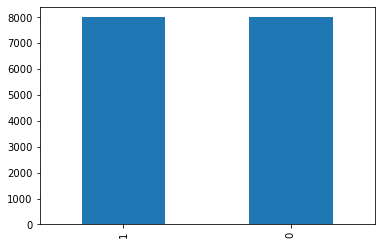

In [16]:
df['category'].value_counts().plot.bar();

# See sample image

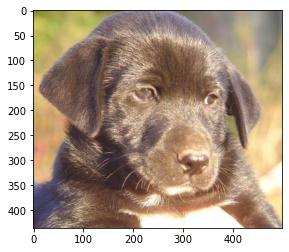

In [49]:
from skimage.io import imread

img = random.choice(filenames)
image = imread(TRAIN_PATH + img)
plt.imshow(image);

Una imagen no es mas que un array de HxWxC píxeles, siendo H(Height) y W(Width) las dimensiones de resolución de la imagen, y C el número de canales. Habrá tres valores por píxel. 

In [50]:
image

array([[[142, 146,  51],
        [142, 146,  51],
        [141, 145,  50],
        ...,
        [119, 117, 122],
        [122, 120, 125],
        [124, 122, 127]],

       [[141, 145,  51],
        [141, 145,  51],
        [140, 144,  50],
        ...,
        [119, 117, 122],
        [122, 120, 125],
        [124, 122, 127]],

       [[140, 144,  50],
        [140, 144,  50],
        [139, 143,  49],
        ...,
        [120, 118, 123],
        [122, 120, 125],
        [125, 123, 128]],

       ...,

       [[ 70,  60,  87],
        [ 70,  60,  87],
        [ 70,  60,  87],
        ...,
        [202, 174, 163],
        [198, 170, 159],
        [194, 166, 155]],

       [[ 70,  60,  87],
        [ 71,  61,  88],
        [ 71,  61,  88],
        ...,
        [203, 175, 164],
        [198, 170, 159],
        [193, 165, 154]],

       [[ 71,  61,  88],
        [ 71,  61,  88],
        [ 72,  62,  89],
        ...,
        [195, 167, 156],
        [190, 162, 151],
        [184, 156, 145]]

# Resize image
Cargar todas las imágenes a la vez es un problema ya que son un total de 25000 (unos 500MB la carpeta de train). Este proceso require mucha memoria, por lo que tendremos que aplicarle un resize a cada imagen para bajarlas de resolución. Esto también nos sirve para solventar el problema de tener imágenes con distintas resoluciones.

Tamaño imagen original: (436, 499, 3)
Tamaño imagen reshape: (32, 32, 3)
Maximo valor por pixel: 255


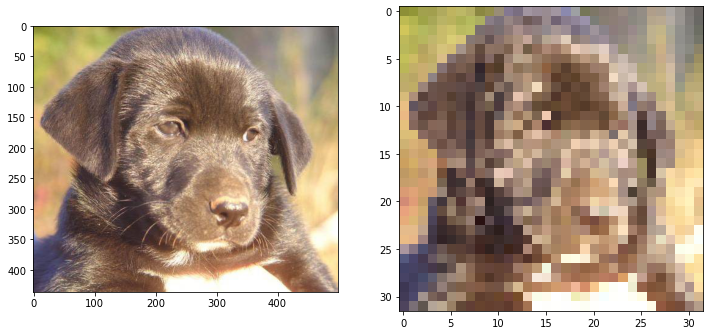

In [52]:
plt.figure(figsize=(12, 12))

imagesmall = cv2.resize(image, (IMAGE_WIDTH, IMAGE_HEIGHT))

print("Tamaño imagen original:", image.shape)
print("Tamaño imagen reshape:", imagesmall.shape)
print("Maximo valor por pixel:", np.max(imagesmall))

# Original image
plt.subplot(1, 2, 1)
plt.imshow(image)

# Resized image
plt.subplot(1, 2, 2)
plt.imshow(imagesmall);

# Color
Podríamos cargar las imágenes como blanco y negro, de esta forma se reduciría el espacio de features considerablemente al contar con un único canal

(222, 284)

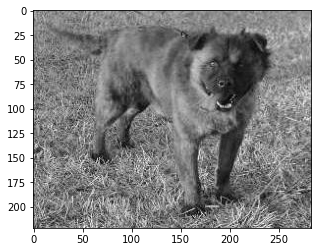

In [58]:
sample = random.choice(filenames)

image = cv2.imread(filename =TRAIN_PATH + sample, flags =cv2.IMREAD_GRAYSCALE)
plt.imshow(image, cmap='gray');
image.shape

# Load data
Llega el momento de cargar los datos. Ya no estan sencillo como cuando teníamos datasets en CSVs puesto que ahora hay que cargar miles de archivos en memoria en este notebook. Para ello necesitaremos un programa iterativo que vaya recorriendo los archivos de la carpeta, cargarlos como array de numpy y almacenarlos en un objeto.

In [60]:
def read_data(path, im_size, sample_size):
    X = []
    Y = []

    # MALA PRACTICA
    pics = np.random.choice(os.listdir(path), size=sample_size)

    for file in pics:

        image = imread(os.path.join(path, file))
        smallimage = cv2.resize(image, (IMAGE_WIDTH, IMAGE_HEIGHT))
        X.append(smallimage)

        category = file.split('.')[0]
        if category == 'cat':
            Y.append(0)
        else:
            Y.append(1)

    return np.array(X), np.array(Y)
    

X_train, y_train = read_data(TRAIN_PATH, IMAGE_SIZE, 5000)
X_test, y_test = read_data(TRAIN_PATH, IMAGE_SIZE, 500) # SERIA CON TEST_PATH PERO SE TRAMPEA 

print(X_train.shape)
print(X_test.shape)

(5000, 32, 32, 3)
(500, 32, 32, 3)


(32, 32, 3)


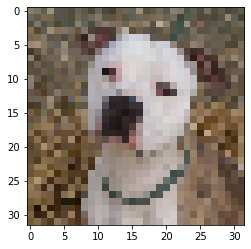

In [61]:
print(X_train[0].shape)
plt.imshow(X_train[0]);

In [62]:
X_train[0]

array([[[136, 123, 104],
        [121, 118, 104],
        [ 92,  96,  79],
        ...,
        [ 79,  70,  55],
        [ 80,  78,  66],
        [ 98,  91,  72]],

       [[103, 105, 102],
        [101,  90,  70],
        [123, 106,  80],
        ...,
        [144, 137, 118],
        [ 96,  91,  88],
        [ 67,  69,  58]],

       [[ 89,  79,  59],
        [120, 122, 112],
        [ 85,  82,  67],
        ...,
        [ 87,  79,  66],
        [103,  98,  77],
        [114, 106,  80]],

       ...,

       [[108,  83,  53],
        [ 30,  17,   2],
        [144, 118,  83],
        ...,
        [133, 108,  86],
        [104,  86,  64],
        [104,  79,  58]],

       [[127,  98,  64],
        [ 51,  32,  19],
        [ 65,  37,  18],
        ...,
        [107,  81,  64],
        [ 99,  73,  57],
        [130,  99,  76]],

       [[114,  90,  61],
        [132, 109,  76],
        [102,  77,  50],
        ...,
        [ 97,  69,  47],
        [100,  79,  62],
        [135, 100,  75]]

# Normalized data
Normalizar los datos hará que entrene mucho mejor la red, al estar todos los pixeles en la misma escala.

In [63]:
print("Min:", np.min(X_train))
print("Max:", np.max(X_train))

Min: 0
Max: 255


In [64]:
X_train = X_train / 255.0
X_test = X_test / 255.0

print("Min:", np.min(X_train))
print("Max:", np.max(X_train))

Min: 0.0
Max: 1.0


# Shuffle data
Como hemos cargado los datos de manera ordenada (primero gatos y luego perros), tendremos que desordenarlos para asegurarnos de que no haya ningún sesgo en el entrenamiento ni en la selección de datos de validación.

In [65]:
y_test

array([0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1,
       0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0,
       1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0,
       0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0,
       1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0,
       0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0,
       1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1,

# Save data
Podemos guardar los arrays de numpy en un archivo `.npz`, de tal manera que luego sea más rápido importarlo

In [66]:
np.savez('data.npz', X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test)

Para cargar

In [ ]:
data = np.load('data.npz')

X_train = data['X_train']
y_train = data['y_train']
X_test = data['X_test']
y_test = data['y_test']

# Build Model

<img src="https://i.imgur.com/ebkMGGu.jpg" width="100%"/>

* **Conv Layer**: extraerá diferentes features de las imagenes
* **Pooling Layer**: Reduce las dimensiones de las imágenes tras una capa convolucional
* **Fully Connected Layer**: Tras las capas convolucionales, aplanamos las features y las introducimos como entrada de una red neuronal normal.
* **Output Layer**: Las predicciones de la red

Para el loss y la metrica, se puede usar un binary_crossentropy, al ser un target binario. O 

In [71]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

# Fit the model

In [72]:
model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.2)

Epoch 1/5
400/400 [==============================] - 10s 21ms/step - loss: 1.0449 - accuracy: 0.5319 - val_loss: 1.1816 - val_accuracy: 0.4970
Epoch 2/5
400/400 [==============================] - 7s 18ms/step - loss: 0.7668 - accuracy: 0.5812 - val_loss: 0.7195 - val_accuracy: 0.5850
Epoch 3/5
400/400 [==============================] - 7s 18ms/step - loss: 0.6797 - accuracy: 0.6214 - val_loss: 0.6193 - val_accuracy: 0.6600
Epoch 4/5
400/400 [==============================] - 7s 18ms/step - loss: 0.6434 - accuracy: 0.6414 - val_loss: 0.7298 - val_accuracy: 0.6120
Epoch 5/5
400/400 [==============================] - 7s 18ms/step - loss: 0.6134 - accuracy: 0.6676 - val_loss: 0.6945 - val_accuracy: 0.6360


# Evaluate
Probemos los datos en el conjunto de test.

In [73]:
model.evaluate(X_test, y_test)

16/16 [==============================] - 0s 12ms/step - loss: 0.7207 - accuracy: 0.5960


[0.7206827402114868, 0.5960000157356262]

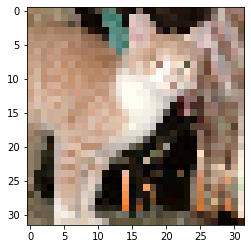

In [74]:
plt.imshow(X_test[0]);

In [75]:
model.predict(X_test[:1])

array([[0.4956098]], dtype=float32)

# Image data generator

In [ ]:
df["category"] = df["category"].replace({0: 'cat', 1: 'dog'})

print("Categorias:", df['category'].unique())
df.head()

In [ ]:
##### CODE #####

In [ ]:
plt.figure(figsize=(12, 12))

for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

In [ ]:
train_df, validate_df = train_test_split(df,
                                         test_size=0.20,
                                         random_state=42)

train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

In [ ]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]

print("Shape train", total_train)
print("Shape validation", total_validate)
validate_df.head()

In [ ]:
train_df.head()

# Training Generator

In [ ]:
train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    TRAIN_PATH, 
    x_col='filename',
    y_col='category',
    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    class_mode='binary',
    batch_size=BATCH_SIZE
)

### Validation Generator

In [ ]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    train_df, 
    TRAIN_PATH, 
    x_col='filename',
    y_col='category',
    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    class_mode='binary',
    batch_size=BATCH_SIZE
)

# Fit Model

In [ ]:
##### CODE #####

In [ ]:
##### CODE #####

In [ ]:
results = model.evaluate(X_test, y_test)
print("test loss, test acc:", results)

# Virtualize Training

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, EPOCHS, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, EPOCHS, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()